- set up environment

In [2]:
# set up environment

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# for Set working folder, etc.
import os
import os.path

# for sampling 
import random

# set working folder
# fw slashes for windows
cwd_desired = "C:/Users/Bonita/Documents/work/velexi/neural networks" 
os.chdir(cwd_desired) 

# test code
# print(os.getcwd())                           

- ETL spectrum files

In [3]:
# etl spectrum files

# turn files into lists and cut off first line
# put into database "spectra"
# turn deleted points (flagged as -1.23e+34) into 0's


# init spectra and class databases
spectra_wd = str(cwd_desired + "/spectra2")
num_samples = len([name for name in os.listdir(spectra_wd) if \
                   os.path.isfile(os.path.join(spectra_wd,name))])
# test code 
print(num_samples)

spectrum_len = 480                                 # 480 >= the BECK spectrometer spectrum length
spectra = np.zeros((num_samples,spectrum_len))             
y = np.zeros((num_samples, 1))

# fill databases
i = 0

# find spectra folder
os.chdir(spectra_wd)

# etl the data
for filename in os.listdir(spectra_wd):
    file_object  = open(filename, 'r').readlines()
    # strip off header, add to matrix 'spectra'
    spectra[i,:] = file_object[1:]                  
    
    # label spectrum class, based on header
    # actinolite: 0, alunite: 1, calcite: 2
    material_name = file_object[0]
    
    # testcode
    # print(material_name)
    
    if material_name.find('Actinolite',)!= -1: #if material name contains actinolite
        y[i,0] = 0
    elif material_name.find('Alun',)!= -1:
        y[i,0] = 1
    else:                   #calcite
        y[i,0] = 2         
               
    # turn deleted points into 0
    for j in range(spectrum_len):  
        if spectra[i,j] <0:
            spectra[i,j]=0                          
    i+=1

# test code
# print(y[:])
# print(spectra[0:2,0])

32


- Load data

In [4]:
# divide up data randomly

# 80% training data 20% test for this pilot
# eventually, 60% training set, 20% validation set, 20% test set
sample_indices = list(range(0, num_samples))
train_set_size = 4*(num_samples//5)
test_set_size= num_samples-train_set_size
train_set_indices = random.sample(sample_indices,train_set_size)
test_set_indices = np.setdiff1d(sample_indices,train_set_indices)     #fixed bug: take remaining samples after making train set

# test code
# print(train_set_indices)
# print(test_set_indices)

# make train and test sets

train_set = spectra[train_set_indices, :]
train_labels = y[train_set_indices, :]
test_set = spectra[test_set_indices, :]
test_labels = y[test_set_indices, :]



- spectrum plots

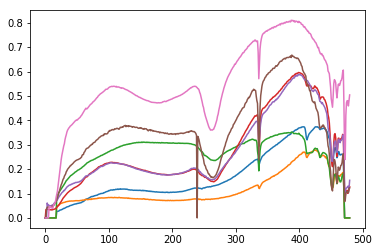

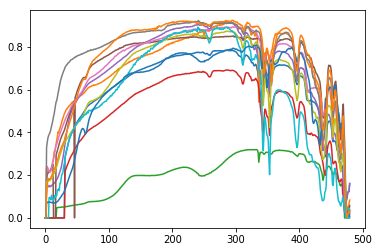

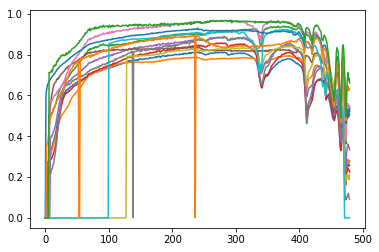

In [5]:
num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(spectra0[i,:])
plt.figure()

for i in range(i1):
    plt.plot(spectra1[i,:])
plt.figure()

for i in range(i2):
    plt.plot(spectra2[i,:])


- ICA plots

(32, 480)
(24, 480)
(480, 24)
(480, 3)
Number of components generated: 3
Number of iterations: 4


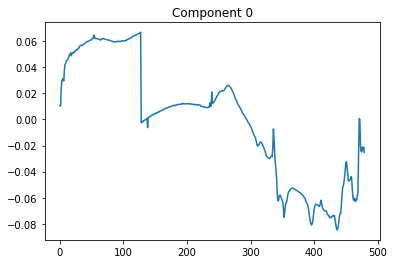

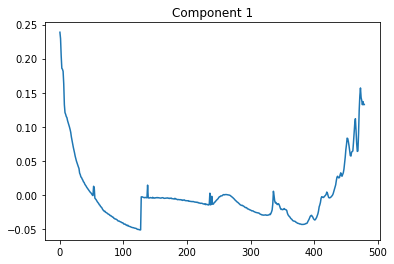

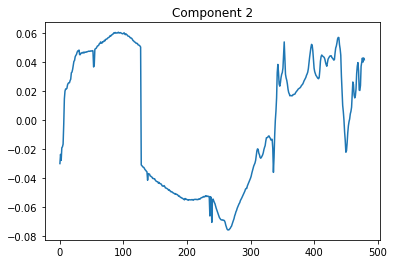

<Figure size 432x288 with 0 Axes>

In [18]:
# --- Generate ICA model

# ICA Parameters
num_components = 3

# Create FastICA object
ica = FastICA(n_components=num_components)

# Fit ICA model
print(spectra.shape)
print(train_set.shape)
X = train_set.T

S_ = ica.fit_transform(X)

print(X.shape)
print(S_.shape)

print("Number of components generated:", num_components)
print("Number of iterations:", ica.n_iter_)

# Display independent components
for i in range(num_components):
    plt.title('Component {}'.format(i))
    plt.plot(S_[:,i])
    plt.figure()

- spectrum plots, individualized

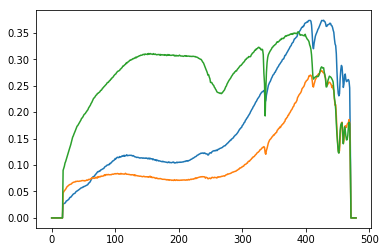

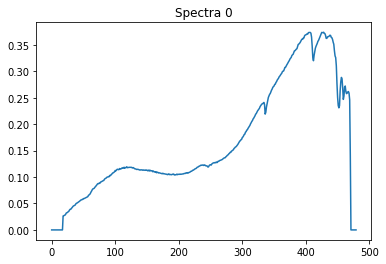

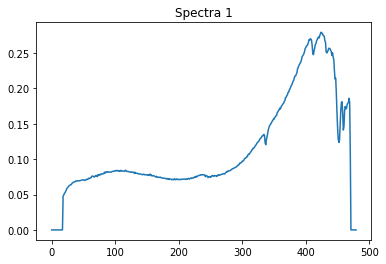

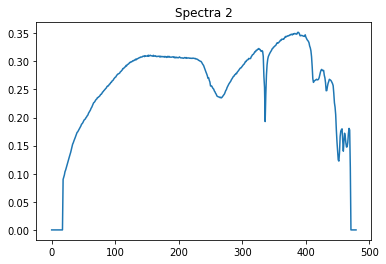

<Figure size 432x288 with 0 Axes>

In [20]:
# display real spectra
num_spectra = 3

for i in range(num_spectra):
    plt.plot(spectra0[i,:])
plt.figure()

for i in range(num_spectra):
    plt.title('Spectra {}'.format(i))
    plt.plot(spectra[i])
    plt.figure()

- reflectance spectra plots, reconstructed from functional group spectra

(24, 3)
(480, 3)
(480, 24)


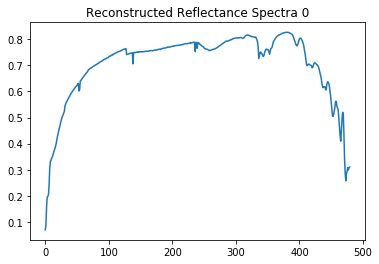

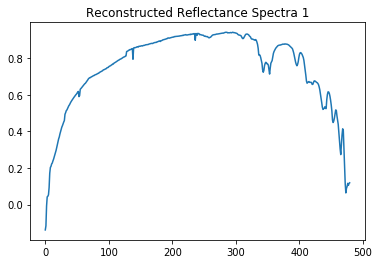

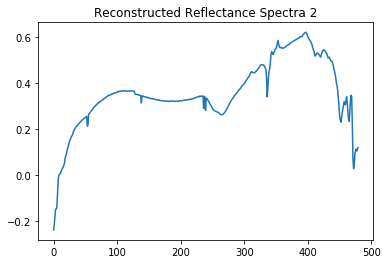

<Figure size 432x288 with 0 Axes>

In [21]:
A_ = ica.mixing_
print(A_.shape)
print(S_.shape)
X_ = np.dot(S_, A_.T) + ica.mean_
print(X_.shape)
for i in range(num_spectra):
    plt.title('Reconstructed Reflectance Spectra {}'.format(i))
    plt.plot(X_[:,i])
    plt.figure()

- functional group spectra plots, deconstructed from reflectance spectra

(3, 24)
(480, 24)
(480, 3)


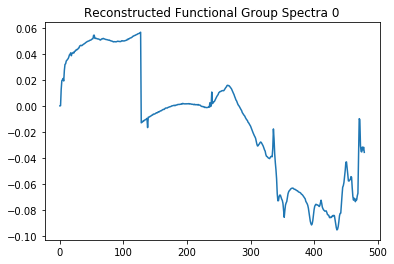

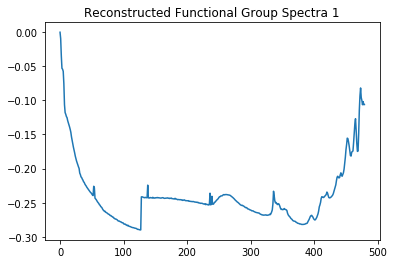

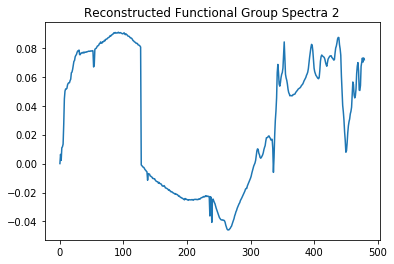

<Figure size 432x288 with 0 Axes>

In [22]:
Ainv = ica.components_
print(Ainv.shape)
print(X.shape)
S_2 = np.dot(X, Ainv.T)
print(S_2.shape)
for i in range(num_components):
    plt.title('Reconstructed Functional Group Spectra {}'.format(i))
    plt.plot(S_2[:,i])
    plt.figure()

In [12]:
# train nn 

model = keras.Sequential([
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(train_set, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 12ms/step - loss: 1.0104 - acc: 0.4583
Epoch 2/15
24/24 [==============================] - 0s 0us/step - loss: 0.9084 - acc: 0.4583
Epoch 3/15
24/24 [==============================] - 0s 0us/step - loss: 0.8824 - acc: 0.5417
Epoch 4/15
24/24 [==============================] - 0s 82us/step - loss: 0.8669 - acc: 0.4583
Epoch 5/15
24/24 [==============================] - 0s 125us/step - loss: 0.8542 - acc: 0.4583
Epoch 6/15
24/24 [==============================] - 0s 83us/step - loss: 0.8280 - acc: 0.5417
Epoch 7/15
24/24 [==============================] - 0s 125us/step - loss: 0.8012 - acc: 0.5833
Epoch 8/15
24/24 [==============================] - 0s 125us/step - loss: 0.7821 - acc: 0.6667
Epoch 9/15
24/24 [==============================] - 0s 125us/step - loss: 0.7606 - acc: 0.7083
Epoch 10/15
24/24 [==============================] - 0s 167us/step - loss: 0.7416 - acc: 0.7083
Epoch 11/15
24/24 [==============================] - 0s 

In [24]:
# train nn on bps ica

model = keras.Sequential([
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(Ainv.T, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 16ms/step - loss: 1.0946 - acc: 0.6667
Epoch 2/15
24/24 [==============================] - 0s 0us/step - loss: 1.0932 - acc: 0.7083
Epoch 3/15
24/24 [==============================] - 0s 488us/step - loss: 1.0919 - acc: 0.6667
Epoch 4/15
24/24 [==============================] - 0s 83us/step - loss: 1.0907 - acc: 0.6667
Epoch 5/15
24/24 [==============================] - 0s 83us/step - loss: 1.0895 - acc: 0.6250
Epoch 6/15
24/24 [==============================] - 0s 125us/step - loss: 1.0883 - acc: 0.6250
Epoch 7/15
24/24 [==============================] - 0s 83us/step - loss: 1.0872 - acc: 0.5833
Epoch 8/15
24/24 [==============================] - 0s 125us/step - loss: 1.0860 - acc: 0.5417
Epoch 9/15
24/24 [==============================] - 0s 125us/step - loss: 1.0849 - acc: 0.5000
Epoch 10/15
24/24 [==============================] - 0s 83us/step - loss: 1.0839 - acc: 0.5000
Epoch 11/15
24/24 [==============================] - 0s 

In [ ]:
# train nn on ktc ica

model = keras.Sequential([
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(Ainv.T, train_labels, epochs=15)